## Content
1. [Data loading](#1.-Data-loading)  
2. [Structure of the data](#2.-Structure-of-the-data)  
3. [Data preprocessing](#3.-Data-preprocessing)  
    3.1 [Context/passage sentence tokenization](#3.1-Context/passage-sentence-tokenization-[1])  
    3.2 [Building labels for correct answers](#3.2-Building-labels-for-correct-answers)  
    3.3 [Word tokenization](#3.3-Word-tokenization-[1])  
    3.4 [Lemmatization](#3.4-Lemmatization-[2])  
    3.5 [Stopwords elimination](#3.5-Stopwords-elimination)  
    3.6 [Summary: a single method for data preprocessing](#3.6-Summary:-a-single-method-for-data-preprocessing)  
4. [Saving preprocessed data](#4.-Saving-preprocessed-data)

## 1. Data loading

In [1]:
import json
import pandas as pd
from pprint import pprint

IN_PATH = '../data/squad/'


def load_data(filename):
    data_frame = pd.read_json(filename)
    data = data_frame.to_dict(orient='list')
    
    return data


train = load_data(IN_PATH + 'train-v1.1.json')
dev = load_data(IN_PATH + 'dev-v1.1.json')

In [2]:
print(dev['data'][0]['paragraphs'][0]['qas'][0])

{u'question': u'Which NFL team represented the AFC at Super Bowl 50?', u'id': u'56be4db0acb8001400a502ec', u'answers': [{u'text': u'Denver Broncos', u'answer_start': 177}, {u'text': u'Denver Broncos', u'answer_start': 177}, {u'text': u'Denver Broncos', u'answer_start': 177}]}


In [3]:
print(dev['data'][0]['paragraphs'][0]['context'])

Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.


## 2. Structure of the data 
** The structure of the data can be seen in the following way:  **
<pre>       
            dataset   
            (dict)   
            /    \  
           /      \  
      'version'   'data'
      (string)    (list)
                  # each element in the list represents an article (dict)  
                     |
                     |
                  articles
                   (dict)
                   /    \
                  /      \
             'title'   'paragraphs'  
             (string)     (list)
                          # each element in the list is an dict with 'qas' and 'context' keys
                             |
                             |
                            pair
                           (dict)
                          /      \
                         /        \
                        /          \
                       /            \
                 'context'          'qas'
                 (string)           (list)
                  # context of      # each element in the list is a dict with 3 keys
                    the questions      |
                    and answers        |
                                       |
                                 question-answer
                                     (dict)
                                    /   |   \
                                   /    |    \
                                  /     |     \
                               'id' 'question' 'answers'
                             (string)(string)   (list)
                                                # each element in the list is an answer dict with 
                                                'text' of the answer and 'answer_start'
                                                  |
                                                  |
                                                answer
                                                (dict)
                                                /     \
                                               /       \
                                        'answer_start' 'text'
                                            (int)     (string)                                   
</pre>

## 3. Data preprocessing

### 3.1 Context/passage sentence tokenization [[1]](#References)
** Let's split sentences for all passages. These sentences are candidate answers for the questions from the same paragraph. **

In [4]:
from nltk.tokenize import sent_tokenize


def tokenize_sent_from_context(dataset):
    for article in dataset['data']:
        for qas_context in article['paragraphs']:
            qas_context['context_sentences'] = sent_tokenize(qas_context['context'])

In [5]:
tokenize_sent_from_context(dev)
tokenize_sent_from_context(train)

In [6]:
pprint(dev['data'][0]['paragraphs'][0]['context_sentences'])

[u'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season.',
 u'The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24\u201310 to earn their third Super Bowl title.',
 u"The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California.",
 u'As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.']


### 3.2 Building labels for correct answers

In [7]:
def get_answer_label(context, sentences_lengths, answer_pos):
    lengths_sum = 0
    
    for i in range(len(sentences_lengths)):
        while not context[lengths_sum].isalnum():
            lengths_sum += 1
            
        lengths_sum += sentences_lengths[i]
        if answer_pos <= lengths_sum:
            return i
        
    # if something is wrong then return -1
    return -1


def building_labels_for_correct_answers(dataset):
    for article in dataset['data']:
        for qas_context in article['paragraphs']:
            # get the number of context_sentences <=> number of candidate answers
            qas_context['nr_candidate_answers'] = len(qas_context['context_sentences'])
            
            # get lengths of context_sentences
            context_sentences_lengths = [len(s) for s in qas_context['context_sentences']]

            # get answers' labels from context
            for qas in qas_context['qas']:
                for answer in qas['answers']:
                    answer['answer_label'] = get_answer_label(qas_context['context'], 
                                                              context_sentences_lengths, 
                                                              answer['answer_start'])

In [8]:
building_labels_for_correct_answers(dev)
building_labels_for_correct_answers(train)

** Let's see if we have labels with value -1. **

In [9]:
dataset = dev
for i in range(len(dataset['data'])):
    for j in range(len(dataset['data'][i]['paragraphs'])):
        for k in range(len(dataset['data'][i]['paragraphs'][j]['qas'])):
            for q in range(len(dataset['data'][i]['paragraphs'][j]['qas'][k]['answers'])):
                if dataset['data'][i]['paragraphs'][j]['qas'][k]['answers'][q]['answer_label'] == -1:
                    print(i,j,k,q,dataset['data'][i]['paragraphs'][j]['qas'][k]['answers'][q]['answer_label'])
                    print('question', dataset['data'][i]['paragraphs'][j]['qas'][k]['question'])
                    context = dataset['data'][i]['paragraphs'][j]['context']
                    pprint(context)
                    print(len(context))
                    pprint([s for s in dataset['data'][i]['paragraphs'][j]['context_sentences']])
                    print(np.sum([len(s) for s in dataset['data'][i]['paragraphs'][j]['context_sentences']]))
                    pprint(dataset['data'][i]['paragraphs'][j]['qas'][k]['answers'])

** Let's plot the distribution of the number of candidate answers for both train and dev set. **

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt


def get_all_nr_candidate_answers(dataset):
    all_nr_candidate_answers = list()
    for article in dataset['data']:
        for qas_context in article['paragraphs']:
            all_nr_candidate_answers.append(qas_context['nr_candidate_answers'])
            
    return all_nr_candidate_answers


def show_hist_for_candidate_answers(dataset):
    x = get_all_nr_candidate_answers(dataset)
    my_plot = plt.hist(x)
    return my_plot


def show_both_hists_for_candidate_answers(train, dev):
    x_train = get_all_nr_candidate_answers(train)
    x_dev = get_all_nr_candidate_answers(dev)
    
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.4)
    
    axs[0].hist(x_train)
    axs[0].set_xlabel('nr of candidate answers (train)')
    axs[0].set_ylabel('frequency')
    
    axs[1].hist(x_dev)
    axs[1].set_xlabel('nr of candidate answers (dev)')
    axs[1].set_ylabel('frequency')

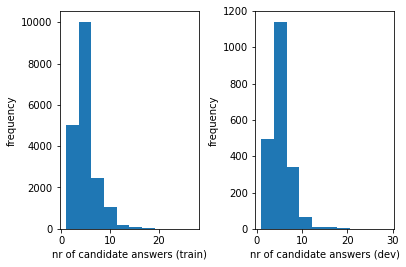

In [11]:
show_both_hists_for_candidate_answers(train, dev)

In [12]:
pprint(dev['data'][0]['paragraphs'][0]['context_sentences'])
pprint(dev['data'][0]['paragraphs'][0]['qas'][7]['question'])
print('text: ' + dev['data'][0]['paragraphs'][0]['qas'][7]['answers'][0]['text'] + '\n')
for i in range(len(dev['data'][0]['paragraphs'][0]['qas'][7]['answers'])):
    print('answer: {}'.format(i))
    print('answer_start: {}'.format(dev['data'][0]['paragraphs'][0]['qas'][7]['answers'][i]['answer_start']))
    print('answer_label: {}\n'.format(dev['data'][0]['paragraphs'][0]['qas'][7]['answers'][i]['answer_label']))

[u'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season.',
 u'The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24\u201310 to earn their third Super Bowl title.',
 u"The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California.",
 u'As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.']
u'What is the AFC short for?'
text: American Football Conference

answer: 0
answer_start: 133
answer_label: 1

answer: 1
answer_start: 133
answer_label: 1

answer: 2
answer_start: 133
answer_label: 1

** Let's plot the distribution of answers' labels for both train and dev set. **


In [13]:
def get_all_answers_labels(dataset):
    all_answers_labels = list()
    for article in dataset['data']:
        for qas_context in article['paragraphs']:
            for qas in qas_context['qas']:
                for answer in qas['answers']:
                    all_answers_labels.append(answer['answer_label'])
            
    return all_answers_labels


def show_both_hists_for_answers_labels(train, dev):
    x_train = get_all_answers_labels(train)
    x_dev = get_all_answers_labels(dev)
    
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.4)
    
    axs[0].hist(x_train)
    axs[0].set_xlabel("answers' label (train)")
    axs[0].set_ylabel('frequency')
    
    axs[1].hist(x_dev)
    axs[1].set_xlabel("answers' label (dev)")
    axs[1].set_ylabel('frequency')

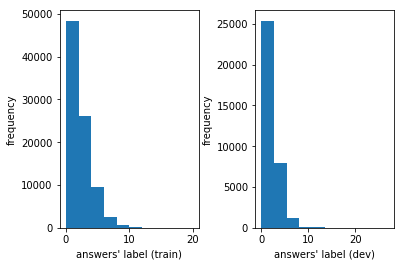

In [14]:
show_both_hists_for_answers_labels(train, dev)

** As a conclusion, the most of candidate answers are in the range [0, 5]. This means that we have small paragraphs with 1-5 sentences. **

### 3.3 Word tokenization [[1]](#References)
** Word tokenization for questions and context with removal of non-alphanumeric tokens.**

In [15]:
from nltk.tokenize import WordPunctTokenizer


def remove_non_alnum(word_list):
    return [word.lower() for word in word_list if word.isalnum()]


def tokenize_words(dataset):
    word_punct_tokenizer = WordPunctTokenizer()
    for article in dataset['data']:
        for qas_context in article['paragraphs']:
            # tokenize all context_sentences
            qas_context['context_sentences_words'] = list()
            for sentence in qas_context['context_sentences']:
                word_list = word_punct_tokenizer.tokenize(sentence)
                qas_context['context_sentences_words'].append(remove_non_alnum(word_list))
            
            # tokenize questions
            for qas in qas_context['qas']:
                question = qas['question']
                word_list = word_punct_tokenizer.tokenize(question)
                qas['question_words'] = remove_non_alnum(word_list)

In [16]:
tokenize_words(dev)

In [17]:
pprint(dev['data'][0]['paragraphs'][0]['context_sentences'][0])
pprint(dev['data'][0]['paragraphs'][0]['context_sentences_words'][0])

u'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season.'
[u'super',
 u'bowl',
 u'50',
 u'was',
 u'an',
 u'american',
 u'football',
 u'game',
 u'to',
 u'determine',
 u'the',
 u'champion',
 u'of',
 u'the',
 u'national',
 u'football',
 u'league',
 u'nfl',
 u'for',
 u'the',
 u'2015',
 u'season']


In [18]:
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question'])
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question_words'])

u'Which NFL team represented the AFC at Super Bowl 50?'
[u'which',
 u'nfl',
 u'team',
 u'represented',
 u'the',
 u'afc',
 u'at',
 u'super',
 u'bowl',
 u'50']


### 3.4 Lemmatization [[2]](2)

In [19]:
from nltk.stem import WordNetLemmatizer


lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    lemmas = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return lemmas


def lemmatization(dataset):
    word_punct_tokenizer = WordPunctTokenizer()
    for article in dataset['data']:
        for qas_context in article['paragraphs']:
            # lemmatize all context_sentences_words
            qas_context['context_sentences_lemmas'] = list()
            for word_list in qas_context['context_sentences_words']:
                qas_context['context_sentences_lemmas'].append(lemmatize_tokens(word_list))
            
            # lemmatize questions
            for qas in qas_context['qas']:
                word_list = qas['question_words']
                qas['question_lemmas'] = lemmatize_tokens(word_list)

In [20]:
lemmatization(dev)

In [21]:
pprint(dev['data'][0]['paragraphs'][0]['context_sentences'][2])
pprint(dev['data'][0]['paragraphs'][0]['context_sentences_words'][2])
pprint(dev['data'][0]['paragraphs'][0]['context_sentences_lemmas'][2])

u"The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."
[u'the',
 u'game',
 u'was',
 u'played',
 u'on',
 u'february',
 u'7',
 u'2016',
 u'at',
 u'levi',
 u's',
 u'stadium',
 u'in',
 u'the',
 u'san',
 u'francisco',
 u'bay',
 u'area',
 u'at',
 u'santa',
 u'clara',
 u'california']
[u'the',
 u'game',
 u'be',
 u'play',
 u'on',
 u'february',
 u'7',
 u'2016',
 u'at',
 u'levi',
 u's',
 u'stadium',
 u'in',
 u'the',
 u'san',
 u'francisco',
 u'bay',
 u'area',
 u'at',
 u'santa',
 u'clara',
 u'california']


In [22]:
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question'])
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question_words'])
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question_lemmas'])

u'Which NFL team represented the AFC at Super Bowl 50?'
[u'which',
 u'nfl',
 u'team',
 u'represented',
 u'the',
 u'afc',
 u'at',
 u'super',
 u'bowl',
 u'50']
[u'which',
 u'nfl',
 u'team',
 u'represent',
 u'the',
 u'afc',
 u'at',
 u'super',
 u'bowl',
 u'50']


### 3.5 Stopwords elimination

In [23]:
from nltk.corpus import stopwords


def remove_stopwords(tokens):
    stopwords_set = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in set(stopwords_set)]   
    return filtered_tokens


def stopwords_elimination(dataset):
    for article in dataset['data']:
        for qas_context in article['paragraphs']:
            # remove stopwords from context_sentences_lemmas
            qas_context['context_sentences_lemmas_without_stopwords'] = list()
            for lemmas_list in qas_context['context_sentences_lemmas']:
                qas_context['context_sentences_lemmas_without_stopwords'].append(remove_stopwords(lemmas_list))
            
            # remove stopwords from questions lemmas
            for qas in qas_context['qas']:
                lemmas_list = qas['question_lemmas']
                qas['question_lemmas_without_stopwords'] = remove_stopwords(lemmas_list)

In [24]:
stopwords_elimination(dev)

In [25]:
pprint(dev['data'][0]['paragraphs'][0]['context_sentences'][2])
pprint(dev['data'][0]['paragraphs'][0]['context_sentences_words'][2])
pprint(dev['data'][0]['paragraphs'][0]['context_sentences_lemmas'][2])
pprint(dev['data'][0]['paragraphs'][0]['context_sentences_lemmas_without_stopwords'][2])

u"The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."
[u'the',
 u'game',
 u'was',
 u'played',
 u'on',
 u'february',
 u'7',
 u'2016',
 u'at',
 u'levi',
 u's',
 u'stadium',
 u'in',
 u'the',
 u'san',
 u'francisco',
 u'bay',
 u'area',
 u'at',
 u'santa',
 u'clara',
 u'california']
[u'the',
 u'game',
 u'be',
 u'play',
 u'on',
 u'february',
 u'7',
 u'2016',
 u'at',
 u'levi',
 u's',
 u'stadium',
 u'in',
 u'the',
 u'san',
 u'francisco',
 u'bay',
 u'area',
 u'at',
 u'santa',
 u'clara',
 u'california']
[u'game',
 u'play',
 u'february',
 u'7',
 u'2016',
 u'levi',
 u'stadium',
 u'san',
 u'francisco',
 u'bay',
 u'area',
 u'santa',
 u'clara',
 u'california']


In [26]:
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question'])
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question_words'])
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question_lemmas'])
pprint(dev['data'][0]['paragraphs'][0]['qas'][0]['question_lemmas_without_stopwords'])

u'Which NFL team represented the AFC at Super Bowl 50?'
[u'which',
 u'nfl',
 u'team',
 u'represented',
 u'the',
 u'afc',
 u'at',
 u'super',
 u'bowl',
 u'50']
[u'which',
 u'nfl',
 u'team',
 u'represent',
 u'the',
 u'afc',
 u'at',
 u'super',
 u'bowl',
 u'50']
[u'nfl', u'team', u'represent', u'afc', u'super', u'bowl', u'50']


### 3.6 Summary: a single method for data preprocessing

In [27]:
def data_preprocessing(dataset):
    tokenize_sent_from_context(dataset)
    building_labels_for_correct_answers(dataset)
    tokenize_words(dataset)
    lemmatization(dataset)
    stopwords_elimination(dataset)

In [28]:
train = load_data(IN_PATH + 'train-v1.1.json')
dev = load_data(IN_PATH + 'dev-v1.1.json')

In [29]:
print('---data_preprocessing---train---')
data_preprocessing(train)
print('---data_preprocessing---dev---')
data_preprocessing(dev)

---data_preprocessing---train---
---data_preprocessing---dev---


## 4. Saving preprocessed data

In [30]:
def save_preprocessed_data(dataset, filename):
    with open(filename, 'w') as f:
        json.dump(dataset, f)
        

save_preprocessed_data(train, IN_PATH + 'train-v1.1-preprocessed.json')
save_preprocessed_data(dev, IN_PATH + 'dev-v1.1-preprocessed.json')

### References
[1] http://textminingonline.com/dive-into-nltk-part-ii-sentence-tokenize-and-word-tokenize  
[2] http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization